# Appendix_F - RoBERTa-MRPC

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **mislabeled data detection** tasks.

- Model: Robert-large (https://arxiv.org/abs/1907.11692; pretrained with publicly available datasets including BOOKCORPUS, WIKIPEDIA, and CC-NEWS)
- Fine-tuning dataset: GLUE-mrpc
    - What is MRPC? The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

References
- https://github.com/huggingface/peft/blob/main/examples/sequence_classification/LoRA.ipynb
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [1]:
!pip install -q -r /kaggle/input/datainf/DataInf/notebooks/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 23.9 MB/s eta 0:00:00


In [2]:
!pip install -q -U huggingface_hub
!pip install diffusers>=0.29.0

In [3]:
import sys
sys.path.append('/kaggle/input/datainf/DataInf/src')
from dataloader import create_dataloaders
from lora_model import LORAEngine
from influence import IFEngine

import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Set up hyperparameters and LoRA models

In [4]:
model_name_or_path="roberta-large"
task="mrpc"
noise_ratio=0.2
batch_size=32
target_modules=["value"]
device="cuda"
num_epochs=10
lr=3e-4

In [5]:
# fine-tuning models
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)
train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn, noisy_datasets=dataloader_outputs

lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

## Fine-tune a model

In [6]:
lora_engine.build_LORA_model()
accuracies = lora_engine.train_LORA_model()
print('------accuracies------')
print(accuracies)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 2: {'accuracy': 0.7058823529411765, 'f1': 0.8219584569732937}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 3: {'accuracy': 0.5563725490196079, 'f1': 0.5530864197530864}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 4: {'accuracy': 0.7034313725490197, 'f1': 0.8207407407407408}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7524509803921569, 'f1': 0.8419405320813772}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 6: {'accuracy': 0.7426470588235294, 'f1': 0.7945205479452054}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 7: {'accuracy': 0.7916666666666666, 'f1': 0.8516579406631763}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 8: {'accuracy': 0.8112745098039216, 'f1': 0.8607594936708861}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.7990196078431373, 'f1': 0.8586206896551725}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 10: {'accuracy': 0.8088235294117647, 'f1': 0.8612099644128114}
------accuracies------
[0.6838235294117647, 0.7058823529411765, 0.5563725490196079, 0.7034313725490197, 0.7524509803921569, 0.7426470588235294, 0.7916666666666666, 0.8112745098039216, 0.7990196078431373, 0.8088235294117647]


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

In [7]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

100%|██████████| 408/408 [00:24<00:00, 16.97it/s]


## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).

In [8]:
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)
influence_engine.compute_hvps(compute_accurate=False)
influence_engine.compute_IF()

## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one case use `time_dict`.

In [9]:
influence_engine.time_dict

defaultdict(list,
            {'identity': 5.0067901611328125e-06,
             'proposed': 16.977966785430908,
             'LiSSA': 85.95835328102112})

`IF_dict` includes all the computed influence function values. Here, `identity` indicates the `Hessian-free` influence computation method. 

In [10]:
influence_engine.IF_dict.keys()

dict_keys(['identity', 'proposed', 'LiSSA'])

## Application to mislabeled data detection task
- We compare the mislabeled data detection ability of different influence computation methods. Given that large influence function values are likely to increase the validation loss, data points with large influence fucntion values are desired to be mislabeled. 
- We inspect data points from the largest to lowest influence function values and evaluate the detection rate. 

In [11]:
n_train=influence_engine.n_train
true_label=np.zeros(n_train)
true_label[noise_index]=1

method_dict={'identity': 'Hessian-free',
            'proposed': 'DataInf',
            'LiSSA': 'LiSSA',
            'Random': 'Random',
            'Full': 'Full'}

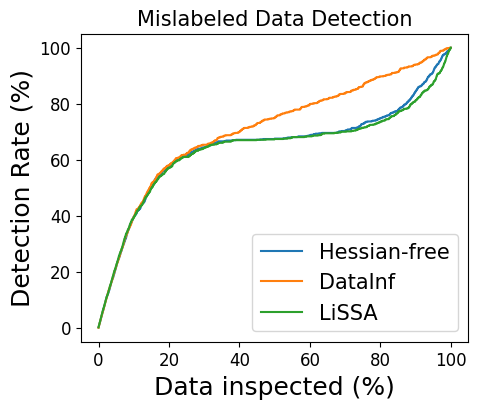

In [12]:
plt.figure(figsize=(5,4))
for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(low_quality_to_high_quality)+1):
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)
    plt.plot(100*np.arange(len(low_quality_to_high_quality))/n_train, 
             detection_rate_list,
             label=method_dict[method])
plt.xlabel('Data inspected (%)', fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.title('Mislabeled Data Detection', fontsize=15)
plt.show()

<h1>Change Starts from here<h1>

In [13]:
import torch
import copy

torch.cuda.empty_cache()
independent_runs = 5
method_accuracies = {}
total_epochs = 10

for method in list(influence_engine.IF_dict.keys()) + ["Random", "Full"]:
    all_accuracies = []
    if method == "Full":
        high_quality_to_low = None
    elif method == "Random":
        n_train = len(noisy_datasets['train'])
        high_quality_to_low = np.random.choice(n_train,
                                       size=int(0.7 * n_train),
                                       replace=False)
    else:
        high_quality_to_low = (np.argsort(influence_engine.IF_dict[method])[::-1])[:int(0.7 * len(influence_engine.IF_dict[method]))]
    
    
    dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size,
                                           select_idx = high_quality_to_low,
                                           given_noisy_datasets = copy.deepcopy(noisy_datasets))
    train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn, _=dataloader_outputs
    for run in np.arange(independent_runs):
        lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                                    target_modules=target_modules,
                                    train_dataloader=train_dataloader,
                                    eval_dataloader=eval_dataloader,
                                    device=device,
                                    num_epochs=total_epochs,
                                    lr=lr,
                                    low_rank=4, 
                                    task=task)
    
        torch.cuda.empty_cache()
        lora_engine.build_LORA_model()
        accuracies = lora_engine.train_LORA_model()
        all_accuracies.append(accuracies)
    method_accuracies[method_dict[method]] = all_accuracies

Map:   0%|          | 0/2567 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 1: {'accuracy': 0.7058823529411765, 'f1': 0.8153846153846155}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 2: {'accuracy': 0.6078431372549019, 'f1': 0.6190476190476191}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.5833333333333334, 'f1': 0.5750000000000001}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 4: {'accuracy': 0.5882352941176471, 'f1': 0.582089552238806}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 5: {'accuracy': 0.47549019607843135, 'f1': 0.3850574712643678}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 6: {'accuracy': 0.6470588235294118, 'f1': 0.6651162790697673}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.7352941176470589, 'f1': 0.7702127659574468}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 8: {'accuracy': 0.6225490196078431, 'f1': 0.6298076923076923}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 9: {'accuracy': 0.6740196078431373, 'f1': 0.7011235955056179}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 10: {'accuracy': 0.6666666666666666, 'f1': 0.6909090909090909}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.31862745098039214, 'f1': 0.0071428571428571435}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.6421568627450981, 'f1': 0.6711711711711712}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 3: {'accuracy': 0.6985294117647058, 'f1': 0.7410526315789473}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 4: {'accuracy': 0.6936274509803921, 'f1': 0.7252747252747254}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 5: {'accuracy': 0.7181372549019608, 'f1': 0.7516198704103673}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 6: {'accuracy': 0.6642156862745098, 'f1': 0.6893424036281179}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 7: {'accuracy': 0.7671568627450981, 'f1': 0.8088531187122737}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 8: {'accuracy': 0.6985294117647058, 'f1': 0.7320261437908496}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 9: {'accuracy': 0.7696078431372549, 'f1': 0.8097165991902834}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 10: {'accuracy': 0.7181372549019608, 'f1': 0.753747323340471}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 1: {'accuracy': 0.5882352941176471, 'f1': 0.659919028340081}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.7352941176470589, 'f1': 0.7938931297709925}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 3: {'accuracy': 0.6323529411764706, 'f1': 0.6527777777777778}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.7475490196078431, 'f1': 0.7893660531697342}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 5: {'accuracy': 0.7083333333333334, 'f1': 0.7396061269146609}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.6470588235294118, 'f1': 0.6651162790697673}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.678921568627451, 'f1': 0.7082405345211581}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.7647058823529411, 'f1': 0.804878048780488}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 9: {'accuracy': 0.7058823529411765, 'f1': 0.7391304347826088}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 10: {'accuracy': 0.7132352941176471, 'f1': 0.7483870967741936}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 1: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.33578431372549017, 'f1': 0.05574912891986063}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 3: {'accuracy': 0.5563725490196079, 'f1': 0.5322997416020672}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 4: {'accuracy': 0.6544117647058824, 'f1': 0.674364896073903}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 5: {'accuracy': 0.7377450980392157, 'f1': 0.7737843551797039}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.6642156862745098, 'f1': 0.6850574712643679}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 7: {'accuracy': 0.7426470588235294, 'f1': 0.7780126849894291}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.678921568627451, 'f1': 0.7042889390519186}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.6740196078431373, 'f1': 0.6984126984126985}


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 10: {'accuracy': 0.6985294117647058, 'f1': 0.728476821192053}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.5245098039215687, 'f1': 0.5245098039215687}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.7230392156862745, 'f1': 0.7707910750507099}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 3: {'accuracy': 0.7328431372549019, 'f1': 0.7733887733887733}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.6936274509803921, 'f1': 0.7276688453159041}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 5: {'accuracy': 0.6715686274509803, 'f1': 0.6954545454545454}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 6: {'accuracy': 0.7745098039215687, 'f1': 0.8188976377952756}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.6348039215686274, 'f1': 0.6477541371158392}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.6887254901960784, 'f1': 0.7184035476718404}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 9: {'accuracy': 0.6274509803921569, 'f1': 0.638095238095238}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 10: {'accuracy': 0.6568627450980392, 'f1': 0.6774193548387096}


Map:   0%|          | 0/2567 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 2: {'accuracy': 0.4387254901960784, 'f1': 0.32047477744807124}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.6004901960784313, 'f1': 0.6270022883295194}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 4: {'accuracy': 0.4730392156862745, 'f1': 0.3977591036414566}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 5: {'accuracy': 0.5882352941176471, 'f1': 0.5882352941176471}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.5049019607843137, 'f1': 0.46276595744680854}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 7: {'accuracy': 0.5098039215686274, 'f1': 0.4736842105263157}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.5686274509803921, 'f1': 0.5686274509803921}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 9: {'accuracy': 0.5588235294117647, 'f1': 0.5522388059701492}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 10: {'accuracy': 0.5686274509803921, 'f1': 0.5707317073170731}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.6078431372549019, 'f1': 0.7269624573378839}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.7205882352941176, 'f1': 0.817891373801917}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.5343137254901961, 'f1': 0.5202020202020202}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.4632352941176471, 'f1': 0.38309859154929576}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 5: {'accuracy': 0.5931372549019608, 'f1': 0.6066350710900474}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 6: {'accuracy': 0.6446078431372549, 'f1': 0.6840958605664488}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.44607843137254904, 'f1': 0.33136094674556216}


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Epoch 8: {'accuracy': 0.5367647058823529, 'f1': 0.5141388174807199}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.5147058823529411, 'f1': 0.4761904761904761}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 10: {'accuracy': 0.5269607843137255, 'f1': 0.5012919896640826}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.6715686274509803, 'f1': 0.7705479452054795}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 2: {'accuracy': 0.37745098039215685, 'f1': 0.19620253164556964}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 3: {'accuracy': 0.47058823529411764, 'f1': 0.39999999999999997}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 4: {'accuracy': 0.4877450980392157, 'f1': 0.4242424242424243}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 5: {'accuracy': 0.6053921568627451, 'f1': 0.6229508196721312}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.6544117647058824, 'f1': 0.6901098901098901}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 7: {'accuracy': 0.5049019607843137, 'f1': 0.45989304812834225}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 8: {'accuracy': 0.5269607843137255, 'f1': 0.4934383202099738}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 9: {'accuracy': 0.5588235294117647, 'f1': 0.5544554455445545}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 10: {'accuracy': 0.5784313725490197, 'f1': 0.5845410628019324}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 1: {'accuracy': 0.31862745098039214, 'f1': 0.0071428571428571435}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 2: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 3: {'accuracy': 0.40441176470588236, 'f1': 0.2476780185758514}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 4: {'accuracy': 0.5563725490196079, 'f1': 0.5394402035623409}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 5: {'accuracy': 0.6348039215686274, 'f1': 0.6526806526806527}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 6: {'accuracy': 0.6274509803921569, 'f1': 0.6481481481481481}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 7: {'accuracy': 0.49264705882352944, 'f1': 0.42659279778393344}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 8: {'accuracy': 0.5833333333333334, 'f1': 0.5792079207920792}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 9: {'accuracy': 0.6372549019607843, 'f1': 0.6636363636363638}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 10: {'accuracy': 0.5563725490196079, 'f1': 0.5440806045340051}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 1: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.678921568627451, 'f1': 0.7342799188640974}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 3: {'accuracy': 0.3627450980392157, 'f1': 0.1503267973856209}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.44362745098039214, 'f1': 0.33431085043988273}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 5: {'accuracy': 0.678921568627451, 'f1': 0.7182795698924732}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 6: {'accuracy': 0.571078431372549, 'f1': 0.5614035087719298}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 7: {'accuracy': 0.5857843137254902, 'f1': 0.5927710843373495}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 8: {'accuracy': 0.6078431372549019, 'f1': 0.6190476190476191}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.625, 'f1': 0.6450116009280743}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 10: {'accuracy': 0.6004901960784313, 'f1': 0.6091127098321343}


Map:   0%|          | 0/2567 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.32107843137254904, 'f1': 0.014234875444839857}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 2: {'accuracy': 0.47549019607843135, 'f1': 0.41530054644808745}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.6666666666666666, 'f1': 0.6964285714285714}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 4: {'accuracy': 0.6617647058823529, 'f1': 0.684931506849315}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 5: {'accuracy': 0.7549019607843137, 'f1': 0.7991967871485943}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 6: {'accuracy': 0.7671568627450981, 'f1': 0.8140900195694717}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 7: {'accuracy': 0.7647058823529411, 'f1': 0.804878048780488}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.6862745098039216, 'f1': 0.7130044843049328}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 9: {'accuracy': 0.6519607843137255, 'f1': 0.6697674418604651}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 10: {'accuracy': 0.7230392156862745, 'f1': 0.756989247311828}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1: {'accuracy': 0.7009803921568627, 'f1': 0.8145896656534954}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 2: {'accuracy': 0.7647058823529411, 'f1': 0.8441558441558442}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 3: {'accuracy': 0.6862745098039216, 'f1': 0.7253218884120172}


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Epoch 4: {'accuracy': 0.6372549019607843, 'f1': 0.655813953488372}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 5: {'accuracy': 0.5588235294117647, 'f1': 0.5384615384615384}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.5245098039215687, 'f1': 0.47849462365591394}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 7: {'accuracy': 0.6740196078431373, 'f1': 0.7011235955056179}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 8: {'accuracy': 0.7181372549019608, 'f1': 0.7578947368421053}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.6470588235294118, 'f1': 0.663551401869159}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 10: {'accuracy': 0.6617647058823529, 'f1': 0.6863636363636363}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 1: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.4362745098039216, 'f1': 0.31137724550898205}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 3: {'accuracy': 0.5882352941176471, 'f1': 0.5942028985507247}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 4: {'accuracy': 0.5220588235294118, 'f1': 0.4827586206896552}


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Epoch 5: {'accuracy': 0.6544117647058824, 'f1': 0.6758620689655173}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 6: {'accuracy': 0.7990196078431373, 'f1': 0.8475836431226766}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 7: {'accuracy': 0.8063725490196079, 'f1': 0.8545119705340699}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.7205882352941176, 'f1': 0.7543103448275862}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 9: {'accuracy': 0.7205882352941176, 'f1': 0.7574468085106384}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 10: {'accuracy': 0.7083333333333334, 'f1': 0.7407407407407407}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.7254901960784313, 'f1': 0.7918215613382898}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 3: {'accuracy': 0.46568627450980393, 'f1': 0.37714285714285717}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 4: {'accuracy': 0.6617647058823529, 'f1': 0.6891891891891891}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 5: {'accuracy': 0.6617647058823529, 'f1': 0.6863636363636363}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 6: {'accuracy': 0.6348039215686274, 'f1': 0.6494117647058824}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.75, 'f1': 0.7892561983471075}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.7230392156862745, 'f1': 0.756989247311828}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.7230392156862745, 'f1': 0.7631027253668763}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 10: {'accuracy': 0.7058823529411765, 'f1': 0.7435897435897435}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 1: {'accuracy': 0.3161764705882353, 'f1': 0.0}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.37745098039215685, 'f1': 0.19620253164556964}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 3: {'accuracy': 0.4632352941176471, 'f1': 0.376068376068376}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 4: {'accuracy': 0.7034313725490197, 'f1': 0.7441860465116278}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 5: {'accuracy': 0.6887254901960784, 'f1': 0.7171492204899778}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 6: {'accuracy': 0.6691176470588235, 'f1': 0.6938775510204082}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 7: {'accuracy': 0.6593137254901961, 'f1': 0.6819221967963387}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 8: {'accuracy': 0.7230392156862745, 'f1': 0.7590618336886993}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.7181372549019608, 'f1': 0.7547974413646056}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 10: {'accuracy': 0.7083333333333334, 'f1': 0.7407407407407407}


Map:   0%|          | 0/2567 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.6642156862745098, 'f1': 0.7842519685039371}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 2: {'accuracy': 0.6862745098039216, 'f1': 0.8128654970760235}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 3: {'accuracy': 0.7181372549019608, 'f1': 0.8275862068965516}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 4: {'accuracy': 0.7083333333333334, 'f1': 0.8221225710014948}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 5: {'accuracy': 0.7254901960784313, 'f1': 0.8282208588957055}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 6: {'accuracy': 0.7598039215686274, 'f1': 0.8237410071942445}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 7: {'accuracy': 0.7818627450980392, 'f1': 0.8533772652388798}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 8: {'accuracy': 0.7843137254901961, 'f1': 0.8405797101449275}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 9: {'accuracy': 0.7573529411764706, 'f1': 0.8426073131955484}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 10: {'accuracy': 0.7720588235294118, 'f1': 0.8457711442786069}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 1: {'accuracy': 0.6397058823529411, 'f1': 0.7537688442211055}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 3: {'accuracy': 0.7034313725490197, 'f1': 0.8202080237741455}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.7426470588235294, 'f1': 0.8367029548989114}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 5: {'accuracy': 0.7426470588235294, 'f1': 0.8361934477379096}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 6: {'accuracy': 0.7573529411764706, 'f1': 0.8216216216216217}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 7: {'accuracy': 0.7745098039215687, 'f1': 0.8486842105263158}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 8: {'accuracy': 0.7941176470588235, 'f1': 0.8571428571428571}


100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


Epoch 9: {'accuracy': 0.7818627450980392, 'f1': 0.8402154398563735}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 10: {'accuracy': 0.7818627450980392, 'f1': 0.846815834767642}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.6053921568627451, 'f1': 0.7284991568296795}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8202080237741455}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 3: {'accuracy': 0.7377450980392157, 'f1': 0.8320251177394035}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 4: {'accuracy': 0.6936274509803921, 'f1': 0.8169838945827232}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 5: {'accuracy': 0.75, 'f1': 0.8311258278145696}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 6: {'accuracy': 0.75, 'f1': 0.8416149068322981}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 7: {'accuracy': 0.7549019607843137, 'f1': 0.823321554770318}


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Epoch 8: {'accuracy': 0.7696078431372549, 'f1': 0.839041095890411}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 9: {'accuracy': 0.7745098039215687, 'f1': 0.8471760797342194}


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 10: {'accuracy': 0.7794117647058824, 'f1': 0.8529411764705881}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 2: {'accuracy': 0.6911764705882353, 'f1': 0.8141592920353982}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 3: {'accuracy': 0.7034313725490197, 'f1': 0.8202080237741455}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.7769607843137255, 'f1': 0.8439108061749572}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 5: {'accuracy': 0.7622549019607843, 'f1': 0.8289241622574955}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 6: {'accuracy': 0.7843137254901961, 'f1': 0.8538205980066446}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 7: {'accuracy': 0.7475490196078431, 'f1': 0.838810641627543}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 8: {'accuracy': 0.7671568627450981, 'f1': 0.8419301164725457}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 9: {'accuracy': 0.7769607843137255, 'f1': 0.836036036036036}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 10: {'accuracy': 0.7892156862745098, 'f1': 0.8537414965986394}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Epoch 2: {'accuracy': 0.7058823529411765, 'f1': 0.8214285714285715}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 3: {'accuracy': 0.7107843137254902, 'f1': 0.8233532934131738}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 4: {'accuracy': 0.7156862745098039, 'f1': 0.8263473053892216}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 5: {'accuracy': 0.7058823529411765, 'f1': 0.8219584569732937}


100%|██████████| 13/13 [00:03<00:00,  3.96it/s]


Epoch 6: {'accuracy': 0.7426470588235294, 'f1': 0.8330683624801272}


100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 7: {'accuracy': 0.7794117647058824, 'f1': 0.8538961038961038}


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 8: {'accuracy': 0.7867647058823529, 'f1': 0.8481675392670157}


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


Epoch 9: {'accuracy': 0.7818627450980392, 'f1': 0.8571428571428572}


100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


Epoch 10: {'accuracy': 0.7794117647058824, 'f1': 0.8484848484848486}


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 2: {'accuracy': 0.7352941176470589, 'f1': 0.8291139240506329}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 3: {'accuracy': 0.7058823529411765, 'f1': 0.8208955223880596}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 4: {'accuracy': 0.7328431372549019, 'f1': 0.7841584158415842}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 5: {'accuracy': 0.7794117647058824, 'f1': 0.8426573426573426}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 6: {'accuracy': 0.7230392156862745, 'f1': 0.8264208909370201}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 7: {'accuracy': 0.7990196078431373, 'f1': 0.8514492753623188}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 8: {'accuracy': 0.8137254901960784, 'f1': 0.8647686832740213}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 9: {'accuracy': 0.8112745098039216, 'f1': 0.8617594254937163}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 10: {'accuracy': 0.8186274509803921, 'f1': 0.8692579505300353}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 2: {'accuracy': 0.7328431372549019, 'f1': 0.8272583201267829}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 3: {'accuracy': 0.7107843137254902, 'f1': 0.8228228228228228}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 4: {'accuracy': 0.7401960784313726, 'f1': 0.8359133126934984}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7745098039215687, 'f1': 0.8511326860841424}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 6: {'accuracy': 0.7549019607843137, 'f1': 0.8452012383900929}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 7: {'accuracy': 0.803921568627451, 'f1': 0.8586572438162545}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 8: {'accuracy': 0.7916666666666666, 'f1': 0.8551959114139693}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 9: {'accuracy': 0.7941176470588235, 'f1': 0.8561643835616439}


100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Epoch 10: {'accuracy': 0.7990196078431373, 'f1': 0.8614864864864864}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 2: {'accuracy': 0.7034313725490197, 'f1': 0.8013136288998357}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 3: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 4: {'accuracy': 0.7622549019607843, 'f1': 0.819366852886406}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7181372549019608, 'f1': 0.7657841140529532}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 6: {'accuracy': 0.7450980392156863, 'f1': 0.795275590551181}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 7: {'accuracy': 0.8088235294117647, 'f1': 0.8686868686868686}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 8: {'accuracy': 0.8186274509803921, 'f1': 0.8678571428571429}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 9: {'accuracy': 0.8308823529411765, 'f1': 0.8795811518324608}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 10: {'accuracy': 0.821078431372549, 'f1': 0.8694096601073344}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 1: {'accuracy': 0.6151960784313726, 'f1': 0.7325383304940374}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 2: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 3: {'accuracy': 0.7377450980392157, 'f1': 0.8320251177394035}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 4: {'accuracy': 0.7573529411764706, 'f1': 0.8266199649737302}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 5: {'accuracy': 0.7524509803921569, 'f1': 0.8404423380726699}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 6: {'accuracy': 0.7892156862745098, 'f1': 0.8557046979865771}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 7: {'accuracy': 0.7916666666666666, 'f1': 0.8631239935587761}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 8: {'accuracy': 0.7965686274509803, 'f1': 0.8571428571428571}


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Epoch 9: {'accuracy': 0.803921568627451, 'f1': 0.8620689655172413}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 10: {'accuracy': 0.7892156862745098, 'f1': 0.8552188552188551}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,248,258 || all params: 356,610,052 || trainable%: 0.3500


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 1: {'accuracy': 0.6985294117647058, 'f1': 0.8183161004431315}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 2: {'accuracy': 0.7083333333333334, 'f1': 0.8210526315789474}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 3: {'accuracy': 0.7132352941176471, 'f1': 0.8191653786707882}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 4: {'accuracy': 0.7450980392156863, 'f1': 0.8409785932721712}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 5: {'accuracy': 0.7818627450980392, 'f1': 0.8504201680672269}


100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


Epoch 6: {'accuracy': 0.7647058823529411, 'f1': 0.8291814946619216}


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Epoch 7: {'accuracy': 0.7867647058823529, 'f1': 0.8532883642495784}


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


Epoch 8: {'accuracy': 0.7769607843137255, 'f1': 0.8525121555915721}


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Epoch 9: {'accuracy': 0.7916666666666666, 'f1': 0.8500881834215168}


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Epoch 10: {'accuracy': 0.7916666666666666, 'f1': 0.8506151142355007}


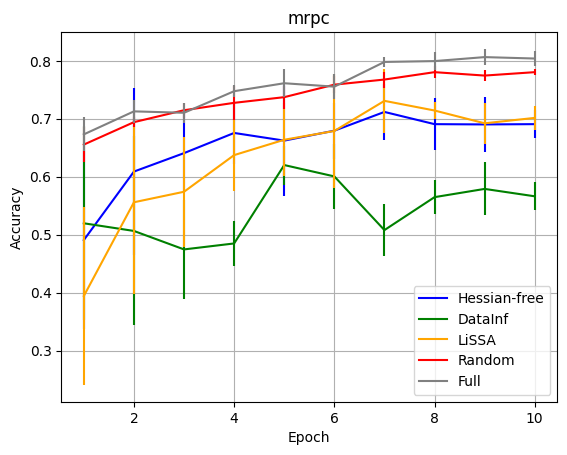

In [14]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, total_epochs+1)
colors = ["blue", "green", "orange", "red", "grey"]

# for i, (model_accuracies, label, color) in enumerate(zip(models, model_labels, colors)):
for i, (method, color) in enumerate(zip(method_dict, colors)):
    model_accuracies = np.array(method_accuracies[method_dict[method]])
    mean_accuracies = np.mean(model_accuracies, axis=0)
    std_accuracies = np.std(model_accuracies, axis=0)
    min_accuracies = mean_accuracies-std_accuracies
    max_accuracies = mean_accuracies+std_accuracies
    
    # Plot the mean accuracy line
    plt.plot(epochs, mean_accuracies, label=method_dict[method], color=color)
    
    # Add vertical lines for min-max range
    for j, epoch in enumerate(epochs):
        plt.vlines(x=epoch, ymin=min_accuracies[j], ymax=max_accuracies[j], color=color)

# Customize the plot
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(task)
plt.legend()
plt.grid()
plt.savefig('plot_output.png')
plt.show()


In [15]:
with open('output.txt', 'w') as file:
    # Loop through the dictionary and write the key-value pairs to the file
    for key, value in method_accuracies.items():
        # Convert the list to a string and write the key-value pair
        file.write(f"{key}: {value}\n")